## Starting model


First of all, we have to import the dataset.


In [2]:
from preprocessing import get_train_test_sets


x_train, x_validate, x_test, y_train, y_validate, y_test = get_train_test_sets()

We'll use a Convoluted Neural Network (CNN) model to solve the problem,
as they have been shown to excel at image classification problems.

The first decision we must make is the model's architecture,
i.e. the number and type of layers.
To start, we'll use a very simple architecture, which we can refine later:

    - 1 convolutional + maxpool layer, with 32 filters.
    - 1 dense layer with 32 neurons.


In [3]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

# Ignore warnings
warnings.filterwarnings("ignore")

image_shape = (28, 28, 1)
# Define model architecture
model = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=image_shape),
        MaxPooling2D(
            pool_size=2
        ),  # down sampling the output instead of 28*28 it is 14*14
        Flatten(),  # flatten out the layers
        Dense(32, activation="relu"),
        Dense(10, activation="softmax"),
    ]
)

2024-05-25 15:12:48.878714: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 15:12:50.018883: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Once the model architecture has been defined we must choose the loss function,
optimizer and performance metric.
The loss function will be the sparse categorical cross entropy,
and the optimizer is the Adam Algorithm optimizer.
As far as I know, those are the most widely used values for CNN image classification problems
in keras.
We don't have any good reason to not use this values.
Therefore, we'll start with these and maybe come back later to try out different options
if they don't work out.

Accuracy is the most intuitive metric for a classification problem and,
in most cases, it's also the variable of interest for business goals.
It's problematic in problems with unbalanced classes, but we don't have to worry
about that as the classes of this dataset are pretty balanced, as we saw in the EDA notebook


In [4]:
# Define loss function, optimizer, and performance metrics
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(lr=0.001),
    metrics=["accuracy"],
)

## Batch size


The batch size is just like any other hyperparameter.
There are some general guidelines for reasonable values,
but at the end of the day we have to experiment with different values to find
the best one.

We'll test a few different values to find the one that best fits our problem.


\*\* The cell bellow takes a long time to execute.
It took me around 5 hours, even using relatively good hardware.


In [18]:
import pandas as pd
import time

batch_sizes = [16, 32, 128, 512, 2048, 4096]
test_epochs = [10, 20, 30]

# Create a pandas DataFrame to store the execution times
execution_time = pd.DataFrame(columns=["epochs"] + [str(el) for el in batch_sizes])
accuracy = pd.DataFrame()

# Test for 10, 20, 30 epochs
for epochs in test_epochs:
    # Create a new df row
    new_exec_time = {"epochs": [epochs]}
    # Try each one of these batch sizes
    for batch_size in batch_sizes:
        # Store starting time
        tic = time.time()
        # Fit model
        history = model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=0,
            validation_data=(x_validate, y_validate),
        )
        # Store finish time
        tac = time.time()
        # Store execution time in new row
        new_exec_time[str(batch_size)] = [tac - tic]
        # Add accuracy
        if epochs == test_epochs[-1]:
            accuracy[str(batch_size)] = history.history["val_accuracy"]

    # Add new row to df
    execution_time = pd.concat(
        [execution_time, pd.DataFrame(new_exec_time)], ignore_index=True
    )

# Save results to csv
execution_time.to_csv("../data/execution_time.csv", index=False)
accuracy.to_csv("../data/accuracy.csv", index=False)

Once that has finished execution, we'll plot the results to get a better idea of the numbers


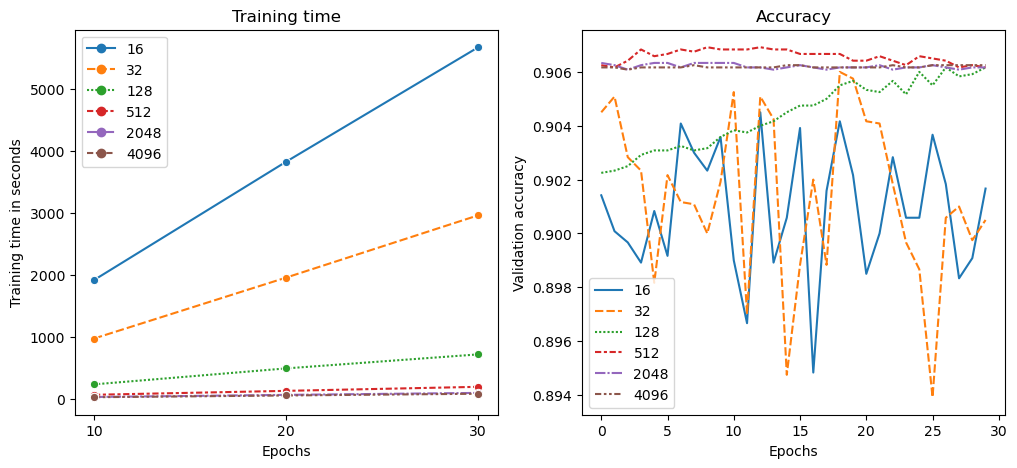

In [ ]:
import pandas as pd
import seaborn as sns

# Read csv files with benchmark data
execution_time = pd.read_csv("../data/execution_time.csv")
accuracy = pd.read_csv("../data/accuracy.csv")

# Create subfigures
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training time plot
sns.lineplot(data=execution_time.set_index("epochs"), ax=ax[0], markers="o")
ax[0].set_xlabel("Epochs")
ax[0].set_xticks([10, 20, 30])
ax[0].set_ylabel("Training time in seconds")
ax[0].set_title("Training time")

# Accuracy plot
sns.lineplot(data=accuracy, ax=ax[1])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Validation accuracy")
_ = ax[1].set_title("Accuracy")

In general, batch size should not have a huge impact in model accuracy, see this paper: https://arxiv.org/pdf/1803.09820 .
All other things being equal and given enough epochs, all the batch sizes should have the same performance.

Therefore, what we are looking for is a small training time and fast converge,
i.e. accuracy improves quickly with the number of epochs.
For both of these metrics, the batch size of 4096 is the best performer,
so that's the one we will use from now on.


In [ ]:
batch_size = 4096